## Uplift modeling experiments on CRITEO-UPLIFTv2 dataset

This code aims to:
- Show how to open and preprocess dataset
- Reproduce Table 3
- Reproduce Figure 3

In [17]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
%matplotlib inline

In [18]:
from tqdm.notebook import tqdm

In [19]:
from um_util import *
# from um_models import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def get_coef_significance(X, Y):    
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y
#     log_reg = sm.Logit(Y_train, X_train).fit()
    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    return pd.read_html(summary.as_html(), header=0, index_col=0)[0], lin_reg

In [21]:
def check_pval(pval):
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [22]:
def ttest(c, e):
    t_val, p = stats.ttest_ind(c, e, equal_var=False) 
    check_pval(p)
    return p

In [23]:
 ! pip install iterative-stratification

## Датасет

In [ ]:
# please download data from: 
# http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

inp_df = pd.read_csv('criteo-uplift-v2.1.csv')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')

X = features
y = 'visit'
t = 'treatment'

In [ ]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(inp_df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

In [ ]:
df = inp_df

In [ ]:
t, p = stats.ttest_ind(df.loc[df['treatment'] == 1, 'visit'], df.loc[df['treatment'] == 0, 'visit'], equal_var=False, random_state=3)
print(f'Full data p-value: {p}')

In [ ]:
df.head()

## Эксперименты с уровнем значимости

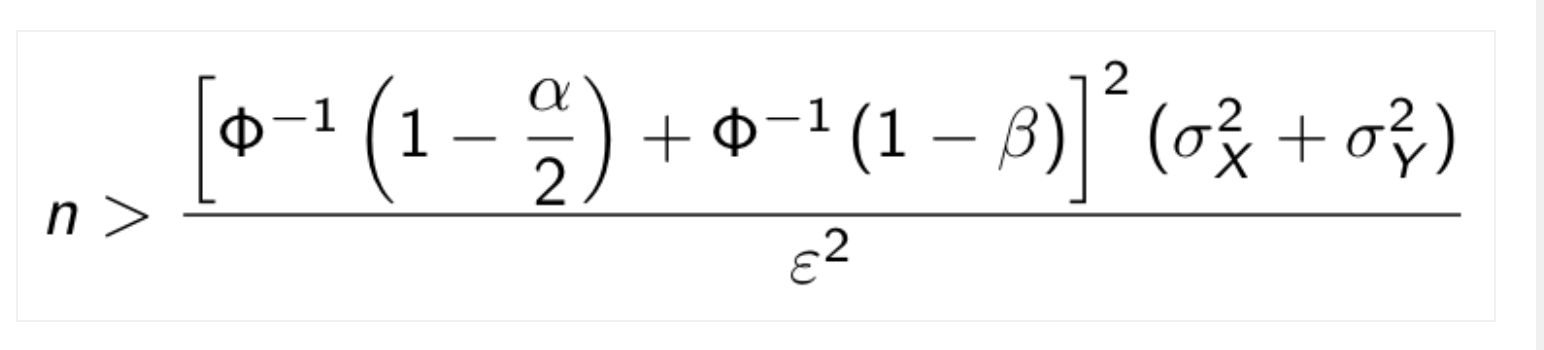

In [24]:
def get_n_samples(alpha, beta, eps, scale=1):
    f_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    f_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    n_min = ((f_alpha + f_beta) ** 2 * (s_c * scale + s_t)) // (scale * eps**2)
    return n_min

In [ ]:
t = df.loc[df['treatment'] == 1, 'visit'] # treatment
c = df.loc[df['treatment'] == 0, 'visit'] # control

s_t = t.var()
s_c = c.var()

p_c = c.mean()
p_t = t.mean()

In [ ]:
scale = t.shape[0] / c.shape[0]
scale

In [123]:
p_c = 0.1
p_t = 0.1
alpha = 0.05
beta = 0.2
eps = 0.05

#start completely synthetic experiment
scale = 1.0
s_c = p_c*(1-p_c)
s_t = p_t*(1-p_t)

control_n = int(get_n_samples(alpha, beta, eps, scale=scale))
treatment_n = int(scale * control_n)
control_n, treatment_n

(565, 565)

In [124]:
from statsmodels.stats.power import tt_ind_solve_power 
import math

In [125]:
# tt_ind_solve_power(alpha=alpha, power=1-beta, ratio=scale, effect_size=0.01)

In [126]:
def t_tests(x, y):
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    
    dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
    
    #original t test    
    t_stat_orig = (x.mean() - y.mean()) / np.sqrt(s_x / n_x + s_y / n_y)
    #p_value_orig = 2*(stats.t.cdf(-abs(t_stat_orig), dof))
    p_value_orig = 2*stats.norm.cdf(-abs(t_stat_orig))
    
    # randomized t test 
#     s_x = p_c * (1 - p_c)
#     s_y = p_t * (1 - p_t)
    b0 = n_x**0.8
    b1 = n_y**0.8
    
    theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                    np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), n_x // 4 + 1))
    theta_x = theta_x[:n_x]
    theta_x = theta_x / np.linalg.norm(theta_x)
    
    theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                       np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), n_y // 4 + 1))
    theta_y = theta_y[:n_y]
    theta_y = theta_y / np.linalg.norm(theta_y)
    
    t_stat_rand = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
    p_value_rand = 2*stats.norm.cdf(-abs(t_stat_rand))
    #p_value_rand = 2*(stats.t.cdf(-abs(t_stat_rand), dof))
    return (t_stat_orig, p_value_orig), (t_stat_rand, p_value_rand)

In [139]:
N_generations = 10000

p_vals_standart = []
p_vals_random = []
t_stat_random = []
t_stat = []
alpha = 0.05

print(p_c)
print(p_t)

for i in tqdm(range(N_generations)):
    y_control = np.random.binomial(1, p_c, size=control_n // 2)
    y_treatment = np.random.binomial(1, p_t, size=treatment_n // 2)
    (t_stat_orig, p_value_orig), (t_stat_rand, p_value_rand) = t_tests(y_control, y_treatment)
    p_vals_standart.append(p_value_orig)
    p_vals_random.append(p_value_rand) 
    t_stat_random.append(t_stat_rand)
    t_stat.append(t_stat_orig)
#     print(p_value_orig, p_value_rand)
#     break
first_error_orig = np.mean(np.array(p_vals_standart) <= alpha)
first_error_rand = np.mean(np.array(p_vals_random) <= alpha)

print(f"Ошибка первого рода в стандартном тесте: {first_error_orig}, в рандомном: {first_error_rand}")

0.1
0.1


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5999.75it/s]

Ошибка первого рода в стандартном тесте: 0.052, в рандомном: 0.0527


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          3.,   2.,   6.,   6.,  11.,   7.,  22.,  19.,  40.,  54.,  67.,
         67.,  98., 117., 143., 175., 186., 256., 248., 334., 331., 426.,
        389., 447., 475., 466., 525., 499., 493., 505., 439., 403., 395.,
        368., 320., 290., 269., 231., 202., 137., 121., 114.,  67.,  63.,
         52.,  31.,  20.,  19.,   9.,   9.,   2.,   7.,   5.,   3.,   0.,
          4.]),
 array([-4.77909152, -4.65367923, -4.52826694, -4.40285464, -4.27744235,
        -4.15203006, -4.02661777, -3.90120547, -3.77579318, -3.65038089,
        -3.5249686 , -3.3995563 , -3.27414401, -3.14873172, -3.02331942,
        -2.89790713, -2.77249484, -2.64708255, -2.52167025, -2.39625796,
        -2.27084567, -2.14543338, -2.02002108, -1.89460879, -1.7691965 ,
        -1.6437842 , -1.51837191, -1.39295962, -1.26754733, -1.14213503,
        -1.01672274, -0.89131045, -0.76589816, -0.64048586, -0.51507357,
        -0.38966128, -0.26424

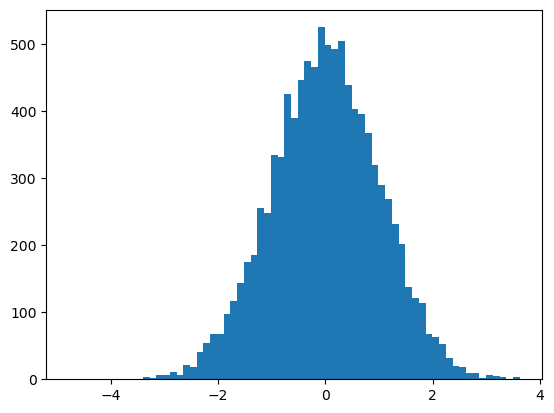

In [136]:
plt.hist(t_stat_random, bins='auto') 

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          2.,   2.,   5.,   4.,   9.,  10.,  15.,  24.,  36.,  48.,  55.,
         62.,  84., 107., 163., 189., 150., 229., 274., 328., 339., 334.,
        419., 389., 348., 492., 543., 582., 565., 521., 416., 404., 380.,
        330., 340., 332., 300., 212., 196., 189., 139.,  97.,  72.,  73.,
         62.,  34.,  31.,  20.,  10.,   4.,  10.,   5.,   5.,   5.,   1.,
          2.,   0.,   1.]),
 array([-4.80047411, -4.67563203, -4.55078994, -4.42594786, -4.30110578,
        -4.1762637 , -4.05142162, -3.92657954, -3.80173746, -3.67689538,
        -3.55205329, -3.42721121, -3.30236913, -3.17752705, -3.05268497,
        -2.92784289, -2.80300081, -2.67815872, -2.55331664, -2.42847456,
        -2.30363248, -2.1787904 , -2.05394832, -1.92910624, -1.80426416,
        -1.67942207, -1.55457999, -1.42973791, -1.30489583, -1.18005375,
        -1.05521167, -0.93036959, -0.80552751, -0.68068542, -0.55584334,
        -0.431001

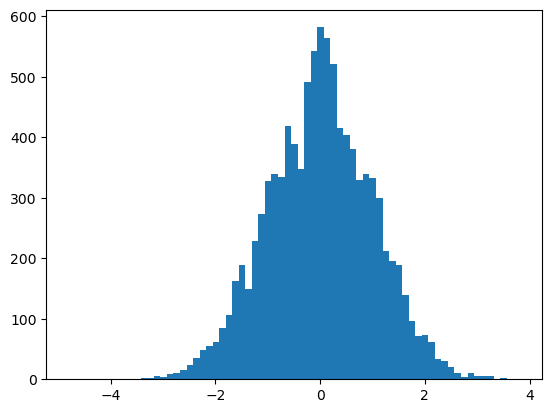

In [137]:
plt.hist(t_stat, bins='auto') 

(array([4.840e+02, 4.530e+02, 5.500e+02, 4.420e+02, 4.690e+02, 5.080e+02,
        5.060e+02, 4.330e+02, 5.310e+02, 3.500e+02, 5.160e+02, 4.520e+02,
        5.310e+02, 4.040e+02, 6.070e+02, 9.700e+01, 9.750e+02, 2.000e+00,
        1.107e+03, 1.000e+00, 5.820e+02]),
 array([1.58290442e-06, 4.76205551e-02, 9.52395274e-02, 1.42858500e-01,
        1.90477472e-01, 2.38096444e-01, 2.85715416e-01, 3.33334389e-01,
        3.80953361e-01, 4.28572333e-01, 4.76191305e-01, 5.23810278e-01,
        5.71429250e-01, 6.19048222e-01, 6.66667194e-01, 7.14286167e-01,
        7.61905139e-01, 8.09524111e-01, 8.57143083e-01, 9.04762056e-01,
        9.52381028e-01, 1.00000000e+00]),
 <BarContainer object of 21 artists>)

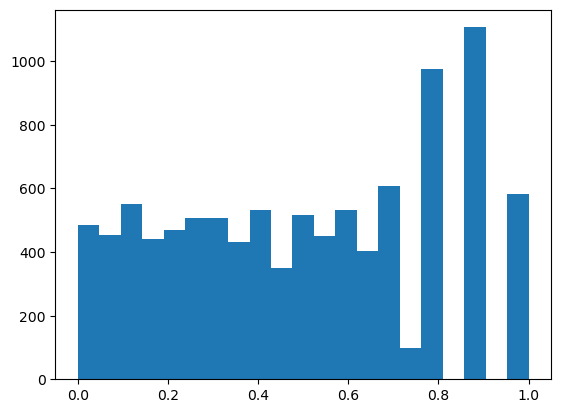

In [138]:
plt.hist(p_vals_standart, bins='auto') 